In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

from collections import Counter
from scipy import stats

## Load Data

In [75]:
data_folder = "../data/hcrc_maptask"
data_path = {
    'rnn_context': os.path.join(data_folder, "hcrc_dialogs_rnn3_c.csv"), # trained with context
    'gpt_context': os.path.join(data_folder, "hcrc_dialogs_gpt1_c.csv"), # trained withOUT context, predicted with
    #'rnn_noc': os.path.join(data_folder, "hcrc_dialogs_rnn6.csv"), # approx training - max_size 1024, no context
    'rnn_3gram':  os.path.join(data_folder, "hcrc_dialogs_rnnx_3.csv"), # trained with 3grams - well official 3gram, tokenizer :| 
}

In [76]:
df = []
for k,v in data_path.items():
    tmp = pd.read_csv(v)
    tmp['model'] = k
    df.append(tmp)

df = pd.concat(df, axis=0)

In [14]:
df.head()

,index,speaker,text,file,context_5,con+text,normalised_h,length,tokens_h,sum_h,xu_h,model
0,0,g,okay the start part is at the top left-hand co...,q7nc7,NaN,okay the start part is at the top left-hand c...,11.702407,13,"[-5.169790744781494, -5.952450275421143, -14.0...",152.131296,1.014601,rnn_context
1,1,f,uh-huh,q7nc7,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,18.736258,5,"[-11.912393569946289, -16.99335289001465, -22....",93.681291,1.206216,rnn_context
2,2,g,okay,q7nc7,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,14.897918,3,"[-15.616093635559082, -3.7928647994995117, -25...",44.693754,1.099170,rnn_context
3,3,f,uh-huh,q7nc7,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,18.734467,5,"[-12.092083930969238, -17.22210121154785, -23....",93.672334,1.206100,rnn_context
4,4,g,ehm you're coming the s-- for three inches dow...,q7nc7,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,12.278788,15,"[-20.495756149291992, -17.547346115112305, -8....",184.181826,1.075322,rnn_context


In [5]:
length_by_file = df.groupby('file')['index'].max().to_dict()

/Users/neako/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/neako/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

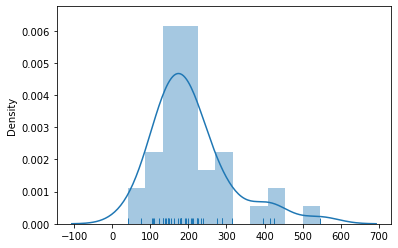

In [11]:
sns.distplot(list(length_by_file.values()), kde=True, rug=True)

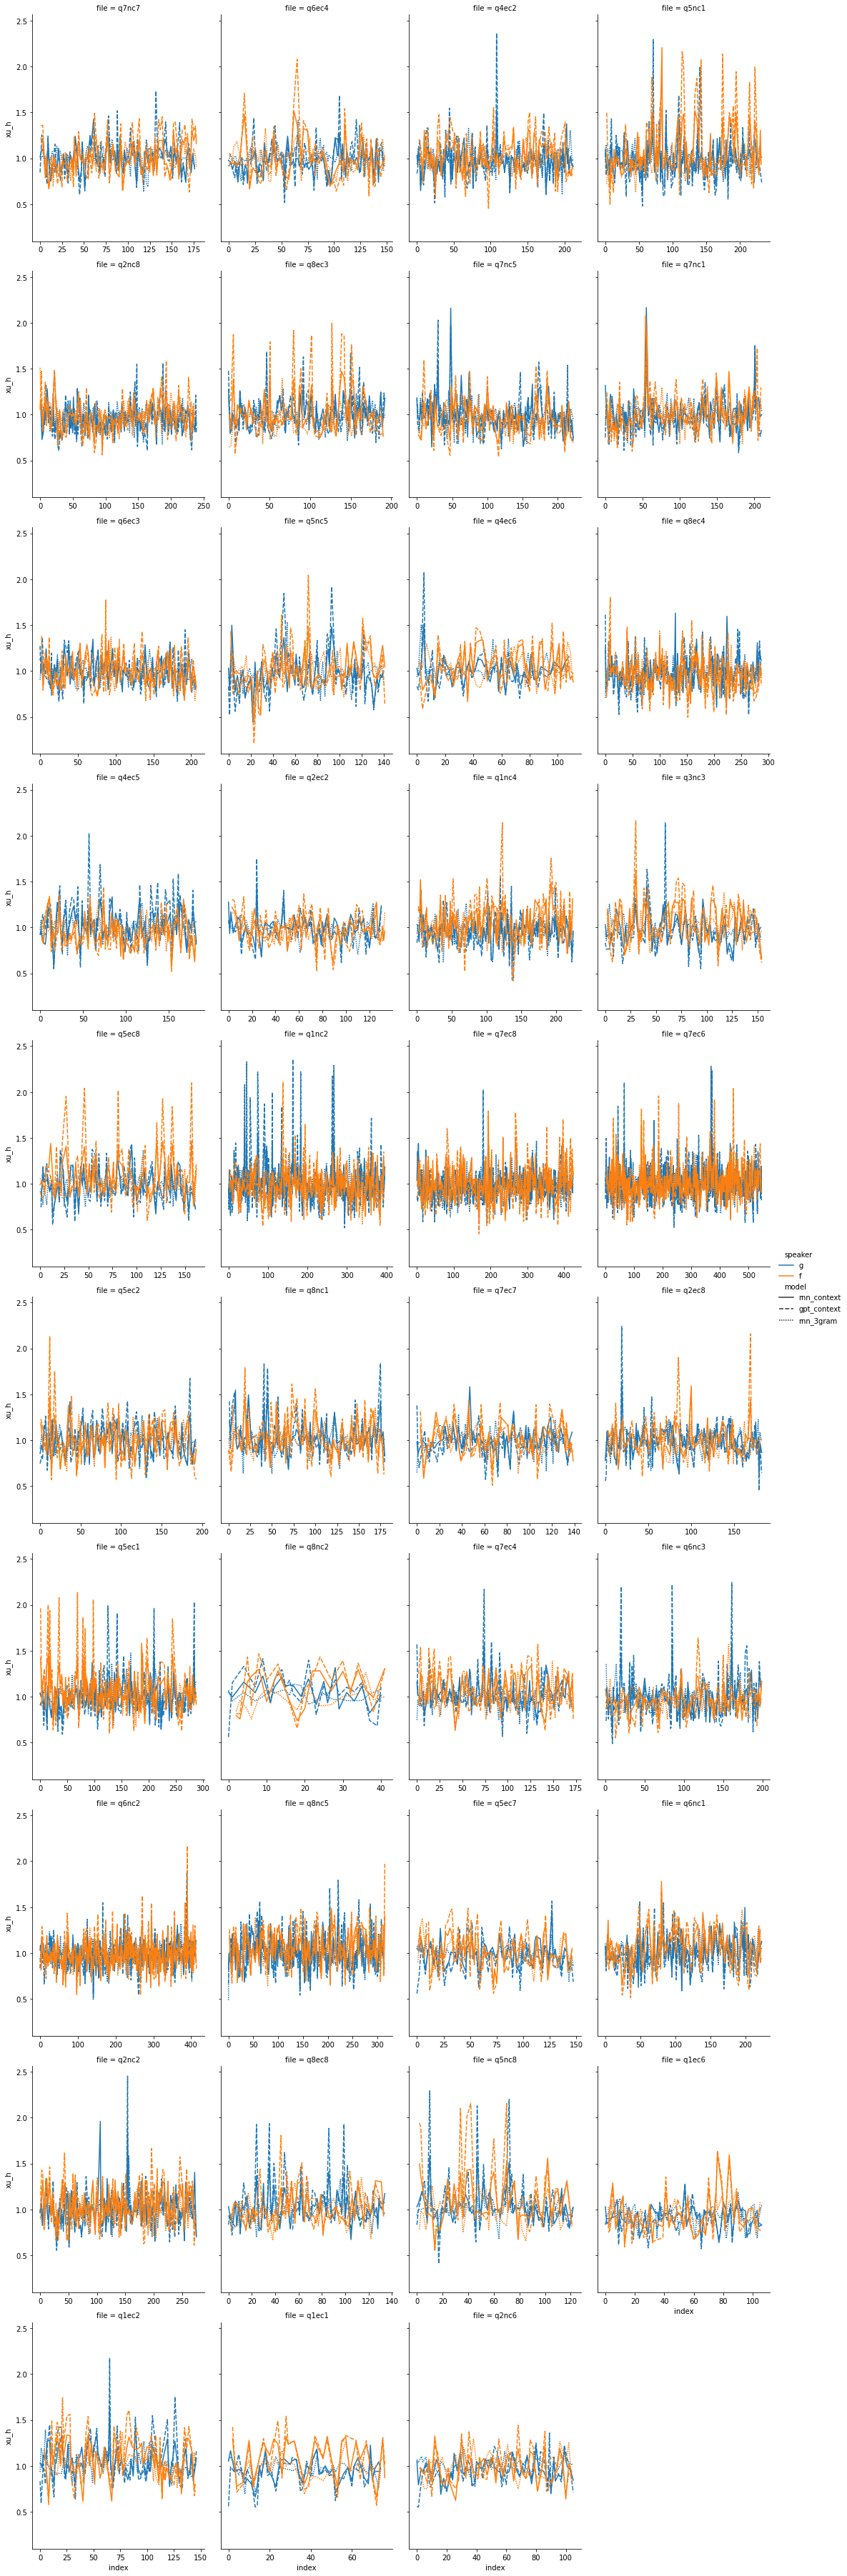

In [77]:
sns.relplot(
    data=df,
    x="index", y="xu_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

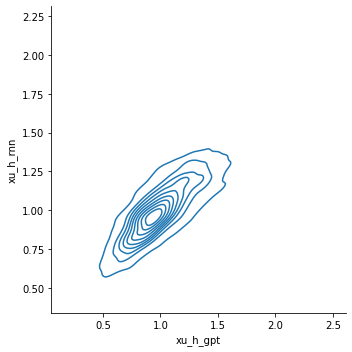

In [152]:
tmp = pd.merge(left=df[df.model == 'gpt_context'].set_index(['file', 'index', 'speaker']), 
            right=df[df.model == 'rnn_context'].set_index(['file', 'index', 'speaker']), 
            left_index=True, right_index=True, how='left', suffixes=('_gpt', '_rnn')).reset_index(drop=False)
sns.displot(data=tmp, x="xu_h_gpt", y="xu_h_rnn", kind="kde")

In [80]:
file_filter = [k for k,v in length_by_file.items() if v > 140]
df_filter = df[df.file.isin(file_filter)]

<AxesSubplot:xlabel='index', ylabel='xu_h'>

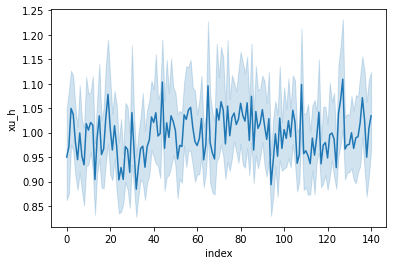

In [29]:
sns.lineplot(data=df_filter[(df_filter['index'] <= 140) & (df_filter.model == 'gpt_context')], x="index", y="xu_h")

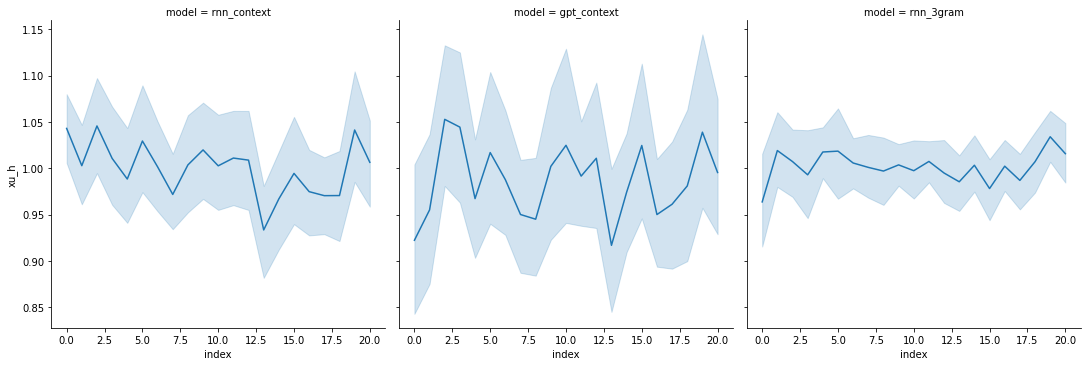

In [154]:
sns.relplot(data=df[(df['index'] <= 20)], x="index", y="xu_h", col="model", kind="line")

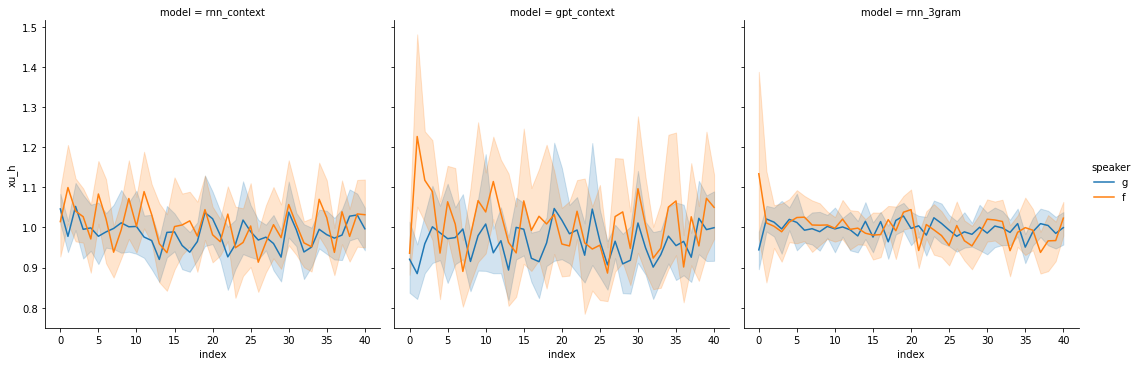

In [155]:
#sns.lineplot(data=df_filter[(df_filter['index'] <= 140) & (df_filter.model == 'gpt_context')], x="index", y="xu_h", hue="speaker")
sns.relplot(data=df[(df['index'] <= 40)], x="index", y="xu_h", col="model", kind="line", hue="speaker")

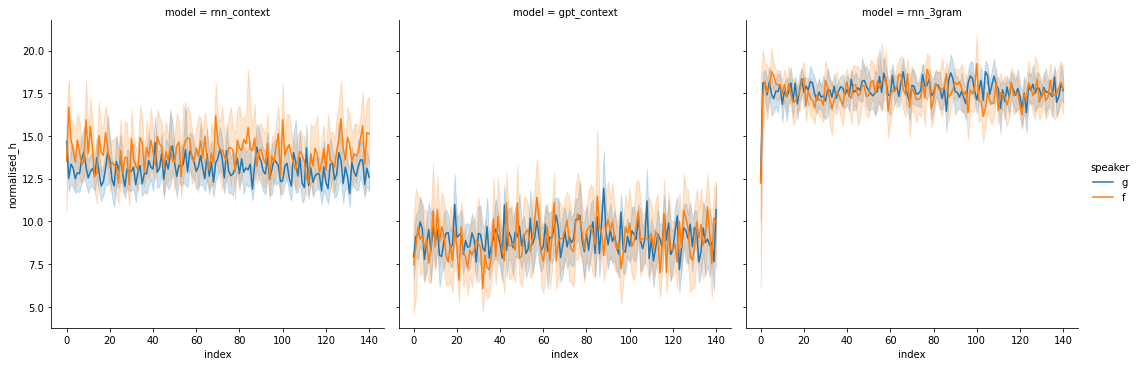

In [83]:
sns.relplot(data=df_filter[(df_filter['index'] <= 140)], x="index", y="normalised_h", col="model", kind="line", hue="speaker")

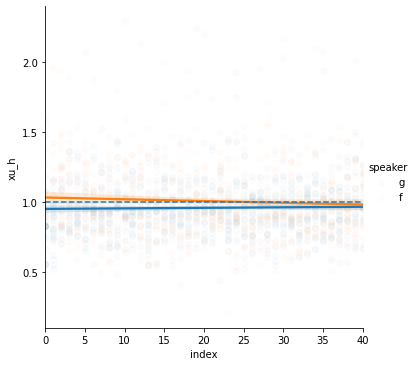

In [157]:
g = sns.lmplot(x="index", y="xu_h", data=df[(df['index'] <= 40) & (df.model == 'gpt_context')],
                  scatter_kws={'alpha':0.02, 'marker':'.'}, hue="speaker")
plt.axhline(y=1, linestyle='dashed')

In [163]:
stats.kendalltau(df[df.model == 'gpt_context'].xu_h, df[df.model == 'gpt_context']['index'])

KendalltauResult(correlation=0.021776089517657544, pvalue=0.0033478986537377434)

## Comparison with Xu & Reitter

In [44]:
df_xu = pd.read_csv('/Users/neako/Downloads/xr_ent_swbd.csv', index_col=0)
df_xu.columns = ['file', 'index', 'speaker', 'ent']
df_xu['index'] = df_xu['index'] - 1
df_xu.head()

,file,index,speaker,ent
1,q1ec1,2,f,3.2645
2,q1ec1,4,f,18.8300
3,q1ec1,7,f,4.8008
4,q1ec1,10,f,3.2645
5,q1ec1,12,f,12.9698


In [45]:
df_gpt = df[df.model == 'gpt_context'].set_index(['file', 'index', 'speaker'])
df_xu = df_xu.set_index(['file', 'index', 'speaker'])

In [51]:
df_merge = pd.merge(df_gpt, df_xu, left_index=True, right_index=True, how='left').reset_index(drop=False)
df_merge.isna().sum()

file             0
index            0
speaker          0
text             0
context_5       39
con+text         0
normalised_h     0
length           0
tokens_h         0
sum_h            0
xu_h             0
model            0
ent              0
dtype: int64

<AxesSubplot:xlabel='ent', ylabel='xu_h'>

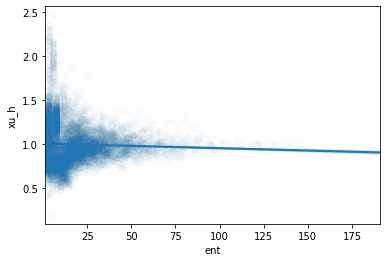

In [52]:
sns.regplot(x="ent", y="xu_h", data=df_merge, scatter_kws={'alpha':0.02, 'marker':'.'})

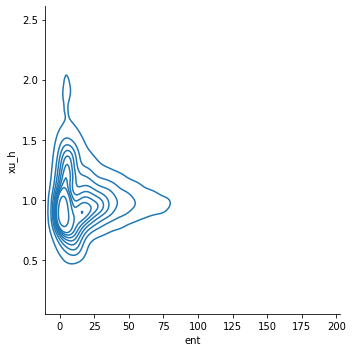

In [53]:
sns.displot(data=df_merge, x="ent", y="xu_h", kind="kde")

In [54]:
df_merge.head()

,file,index,speaker,text,context_5,con+text,normalised_h,length,tokens_h,sum_h,xu_h,model,ent
0,q7nc7,0,g,okay the start part is at the top left-hand co...,NaN,okay the start part is at the top left-hand c...,9.031284,13,"[-2.81382417678833, -6.388303756713867, -7.830...",117.406688,0.844284,gpt_context,35.7900
1,q7nc7,1,f,uh-huh,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,16.689360,5,"[-8.719019889831543, -24.055356979370117, -30....",83.446799,1.354996,gpt_context,7.3260
2,q7nc7,2,g,okay,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,9.151466,3,"[-17.273395538330078, -7.688210487365723, -2.4...",27.454397,1.255447,gpt_context,2.1266
3,q7nc7,3,f,uh-huh,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,16.736341,5,"[-12.508138656616211, -23.24057960510254, -26....",83.681706,1.358810,gpt_context,7.3260
4,q7nc7,4,g,ehm you're coming the s-- for three inches dow...,okay the start part is at the top left-hand co...,okay the start part is at the top left-hand co...,12.512625,15,"[-29.5611515045166, -18.069501876831055, -8.35...",187.689372,1.151567,gpt_context,34.0031


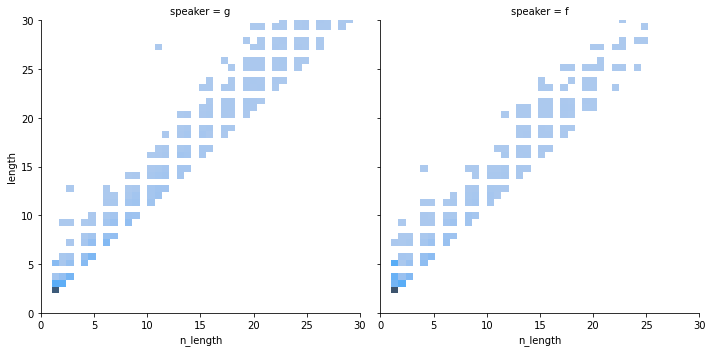

In [92]:
df_merge['n_length'] = df_merge.text.apply(lambda x: len(x.split()))
sns.displot(df_merge, x='n_length', y='length', col="speaker", facet_kws={'xlim':(0,30), 'ylim':(0,30)})

## Checks on original data
Is an increase observed?

In [64]:
df_xu.reset_index(drop=False, inplace=True)

<AxesSubplot:xlabel='index', ylabel='ent'>

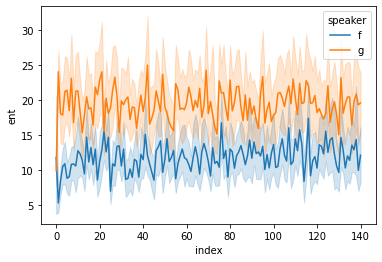

In [159]:
sns.lineplot(data=df_xu[(df_xu['index'] <= 140)], x="index", y="ent", hue="speaker")

(-5.0, 30.0)

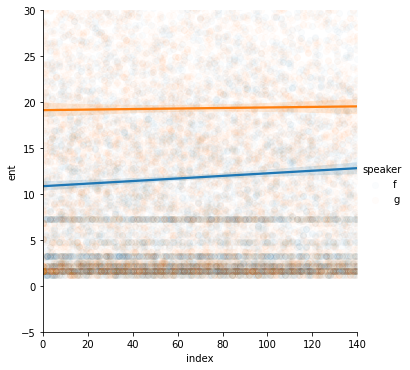

In [74]:
g = sns.lmplot(x="index", y="ent", data=df_xu[(df_xu['index'] <= 140)],
                  scatter_kws={'alpha':0.02, 'marker':'.'}, hue="speaker") # fig, not ax for lmplot
g.axes[0][0].set_ylim(-5, 30)

In [86]:
Counter(' '.join(df_merge[df_merge.speaker == 'f'].text.tolist()).split())

Counter({'uh-huh': 302,
         'yeah': 298,
         'right': 1070,
         'on': 89,
         'the': 1098,
         'right-hand': 46,
         'side': 106,
         'roughly': 8,
         'just': 168,
         'down': 119,
         'there': 61,
         'okay': 308,
         'oops': 2,
         'that': 145,
         'was': 14,
         'no': 170,
         "i've": 157,
         'got': 197,
         'a': 275,
         'gallows': 2,
         'to': 355,
         'left': 124,
         'like': 40,
         'd--': 7,
         'below': 58,
         'oh': 103,
         'i': 352,
         'have': 115,
         'gold': 10,
         'mine': 21,
         'but': 35,
         "it's": 107,
         'good': 9,
         'bit': 40,
         'sorry': 15,
         's--': 23,
         "haven't": 16,
         'underneath': 42,
         'diamond': 9,
         'how': 48,
         'far': 41,
         'five': 6,
         'inches': 20,
         'along': 52,
         'up': 144,
         'near': 8,
         'r-

## Original Guilliani computations

In [146]:
#df_gf = pd.read_csv("/Users/neako/Downloads/gpt2-training_file_1024.csv")
df_gf = pd.read_csv("/Users/neako/Downloads/microsoft-DialoGPT-small_file_1024.csv") # _file
df_gf.head()

,index,speaker,text,file,h,normalised_h,length,tokens_h,tokens,xu_h
0,0,g,okay the start part is at the top left-hand co...,q7nc7,183.075916,14.082763,13,"[-14.232941627502441, -9.225343704223633, -10....","['ay', 'Ġthe', 'Ġstart', 'Ġpart', 'Ġis', 'Ġat'...",1.128250
1,1,f,uh-huh,q7nc7,120.694071,24.138814,5,"[-11.044214248657227, -86.77916717529297, -4.9...","['uh', '-', 'h', 'uh', 'Ġ']",1.591800
2,2,g,okay,q7nc7,14.473869,4.824623,3,"[-6.475625991821289, -1.1664372682571411, -6.8...","['ok', 'ay', 'Ġ']",0.448758
3,3,f,uh-huh,q7nc7,93.211101,18.642220,5,"[-6.855475902557373, -84.7409439086914, -0.894...","['uh', '-', 'h', 'uh', 'Ġ']",1.229335
4,4,g,ehm you're coming the s-- for three inches dow...,q7nc7,202.394239,13.492949,15,"[-8.700074195861816, -5.663690567016602, -7.61...","['eh', 'm', 'Ġyou', ""'re"", 'Ġcoming', 'Ġthe', ...",1.078803


<AxesSubplot:xlabel='index', ylabel='xu_h'>

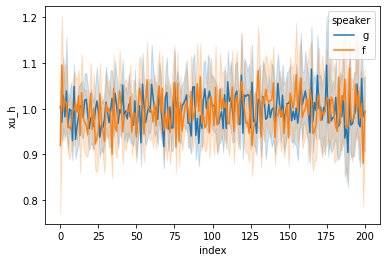

In [117]:
sns.lineplot(data=df_gf[(df_gf['index'] <= 200)], x="index", y="xu_h", hue="speaker")

(0.0, 5.0)

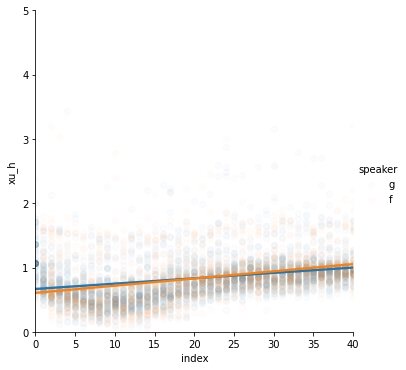

In [160]:
g = sns.lmplot(x="index", y="xu_h", data=df_gf[(df_gf['index'] <= 40)],
                  scatter_kws={'alpha':0.02, 'marker':'.'}, hue="speaker") # fig, not ax for lmplot
g.axes[0][0].set_ylim(0, 5)

In [119]:
df_or = pd.merge(df_gf.set_index(['file', 'index', 'speaker']), df_xu.set_index(['file', 'index', 'speaker']), left_index=True, right_index=True, how='left').reset_index(drop=False)
df_or.isna().sum()

file            0
index           0
speaker         0
text            0
h               0
normalised_h    0
length          0
tokens_h        0
tokens          0
xu_h            0
ent             0
dtype: int64

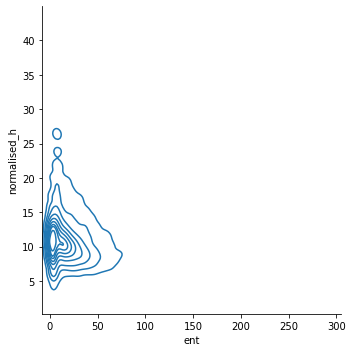

In [120]:
sns.displot(data=df_or, x="ent", y="normalised_h", kind="kde")

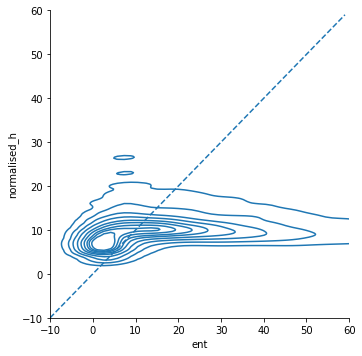

In [137]:
df_gfnc = pd.read_csv("/Users/neako/Downloads/microsoft-DialoGPT-small_-1_150.csv")
df_ornc = pd.merge(df_gfnc.set_index(['file', 'index', 'speaker']), df_xu.set_index(['file', 'index', 'speaker']), left_index=True, right_index=True, how='left').reset_index(drop=False)
x = np.arange(-10,60)

g = sns.displot(data=df_ornc, x="ent", y="normalised_h", kind="kde")
g.axes[0][0].set_xlim(-10, 60)
g.axes[0][0].set_ylim(-10, 60)
plt.plot(x,x, linestyle='dashed')

(0.0, 5.0)

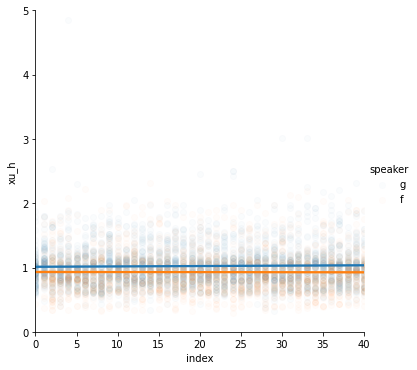

In [161]:
g = sns.lmplot(x="index", y="xu_h", data=df_gfnc[(df_gfnc['index'] <= 40)],
                  scatter_kws={'alpha':0.02, 'marker':'.'}, hue="speaker") # fig, not ax for lmplot
g.axes[0][0].set_ylim(0, 5)

Conclusion: REMOVE THAT FUCKING :5 IN CODE

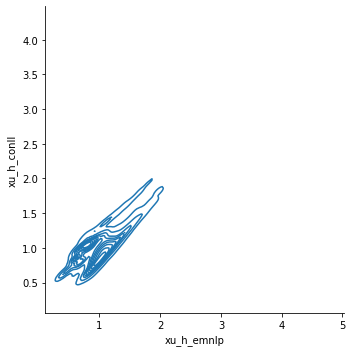

In [139]:
df_gfnc2 = pd.read_csv("/Users/neako/Downloads/microsoft-DialoGPT-small_1024.csv")
df_comp = pd.merge(df_gfnc.set_index(['file', 'index', 'speaker']), df_gfnc2.set_index(['file', 'index', 'speaker']), 
            left_index=True, right_index=True, how='left', suffixes=('_emnlp', '_conll')).reset_index(drop=False)
sns.displot(data=df_comp, x="xu_h_emnlp", y="xu_h_conll", kind="kde")

In [140]:
df_comp

,file,index,speaker,text_emnlp,h_emnlp,normalised_h_emnlp,length_emnlp,xu_h_emnlp,text_conll,h_conll,normalised_h_conll,length_conll,tokens_h,tokens,xu_h_conll
0,q7nc7,0,g,okay the start part is at the top left-hand co...,194.509933,12.967329,15.0,1.352505,okay the start part is at the top left-hand co...,177.369192,12.669228,14.0,"[-11.9165620803833, -1.503597378730774, -8.962...","['ok', 'ay', 'Ġthe', 'Ġstart', 'Ġpart', 'Ġis',...",1.167430
1,q7nc7,1,f,uh-huh,171.609234,11.440616,15.0,1.193267,uh-huh,218.537123,15.609794,14.0,"[-14.570576667785645, -74.39220428466797, -18....","['uh', '-', 'h', 'uh', 'Ġ', '<|endoftext|>', '...",1.438394
2,q7nc7,2,g,okay,89.219382,5.947959,15.0,0.620378,okay,130.146189,9.296156,14.0,"[-11.9165620803833, -1.5035967826843262, -12.7...","['ok', 'ay', 'Ġ', '<|endoftext|>', '<|endoftex...",0.856612
3,q7nc7,3,f,uh-huh,171.609234,11.440616,15.0,1.193267,uh-huh,218.537122,15.609794,14.0,"[-14.570576667785645, -74.39220428466797, -18....","['uh', '-', 'h', 'uh', 'Ġ', '<|endoftext|>', '...",1.438394
4,q7nc7,4,g,ehm you're coming the s-- for three inches dow...,219.217739,13.701109,16.0,1.460851,ehm you're coming the s-- for three inches dow...,199.389128,13.292609,15.0,"[-14.69533920288086, -3.802520513534546, -7.19...","['eh', 'm', 'Ġyou', ""'re"", 'Ġcoming', 'Ġthe', ...",1.243362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27079,q3ec5,110,f,on the left,89.299298,9.922144,9.0,0.914129,on the left,83.567000,10.445875,8.0,"[-13.699182510375977, -2.4914767742156982, -7....","['on', 'Ġthe', 'Ġleft', 'Ġ', '<|endoftext|>', ...",0.871315
27080,q3ec5,111,f,so it's the top corner,103.450900,9.404627,11.0,0.906071,so it's the top corner,94.177780,9.417778,10.0,"[-10.441496849060059, -5.629934310913086, -2.0...","['so', 'Ġit', ""'s"", 'Ġthe', 'Ġtop', 'Ġcorner',...",0.813019
27081,q3ec5,112,g,just so if you just stop you know anywhere,118.258251,10.750750,11.0,1.035761,just so if you just stop you know anywhere,88.170968,8.817097,10.0,"[-11.631726264953613, -6.272302150726318, -10....","['just', 'Ġso', 'Ġif', 'Ġyou', 'Ġjust', 'Ġstop...",0.761163
27082,q3ec5,113,g,right,94.177036,8.561549,11.0,0.824846,right,122.788358,12.278836,10.0,"[-14.30428695678711, -14.051362037658691, -32....","['right', 'Ġ', '<|endoftext|>', '<|endoftext|>...",1.060009


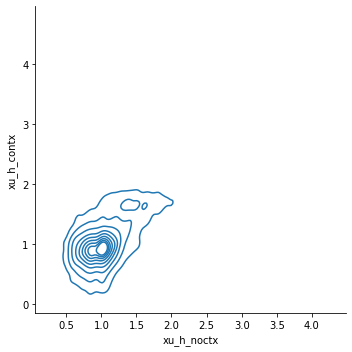

In [147]:
df_comp2 = pd.merge(df_gfnc2.set_index(['file', 'index', 'speaker']), df_gf.set_index(['file', 'index', 'speaker']), 
            left_index=True, right_index=True, how='left', suffixes=('_noctx', '_contx')).reset_index(drop=False)
sns.displot(data=df_comp2, x="xu_h_noctx", y="xu_h_contx", kind="kde")

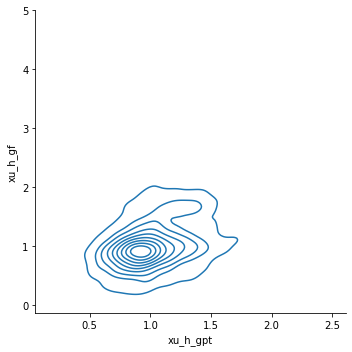

In [153]:
tmp = pd.merge(left=df[df.model == 'gpt_context'].set_index(['file', 'index', 'speaker']), 
            right=df_gf.set_index(['file', 'index', 'speaker']), 
            left_index=True, right_index=True, how='left', suffixes=('_gpt', '_gf')).reset_index(drop=False)
sns.displot(data=tmp, x="xu_h_gpt", y="xu_h_gf", kind="kde")

TODO: 
* test different datasets
    * PB, BNC, SWBD
    * PACO-CHEESE - split by 
* Observe only first 20 sentences
* test with a different function than log_softmax?

## Switchboard

In [3]:
df = pd.read_csv('../data/swbd/swbd_gpt1_c.csv')
df.head()

,index,start,stop,text,speaker,file,context_5,con+text,normalised_h,length,tokens_h,sum_h,xu_h
0,2,0.868125,2.762875,Arch how are you doing tonight,A,sw2013,NaN,Arch how are you doing tonight,7.800255,6,"[-12.76669979095459, -4.548937797546387, -5.17...",46.801528,0.612423
1,6,10.619500,22.121750,Lewisville okay i'm in Garland um have you rea...,A,sw2013,Arch how are you doing tonight,Arch how are you doing tonight Lewisville okay...,9.160225,29,"[-4.256659030914307, -11.524155616760254, -4.0...",265.646520,0.964930
2,29,103.086250,108.539500,you know uh that way old people don't have to ...,B,sw2013,Arch how are you doing tonight Lewisville okay...,Arch how are you doing tonight Lewisville okay...,10.823842,28,"[-6.925611972808838, -13.716020584106445, -5.1...",303.067576,1.143619
3,30,108.539500,116.657250,but uh i wouldn't be surprised if that happens...,B,sw2013,Arch how are you doing tonight Lewisville okay...,Arch how are you doing tonight Lewisville okay...,9.902904,28,"[-5.993398666381836, -4.735257625579834, -3.13...",277.281323,1.046315
4,20,115.417375,121.141125,well they're already talking about freedom of ...,A,sw2013,Arch how are you doing tonight Lewisville okay...,Arch how are you doing tonight Lewisville okay...,9.855591,17,"[-7.03127384185791, -3.8767688274383545, -13.8...",167.545045,1.020111


/Users/neako/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

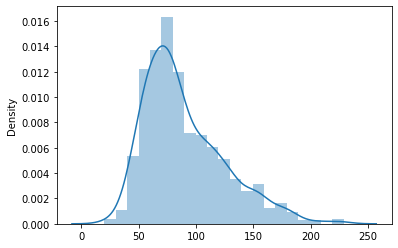

In [166]:
sns.distplot(df.groupby('file')['index'].max().to_list(), kde=True)

<AxesSubplot:xlabel='index', ylabel='xu_h'>

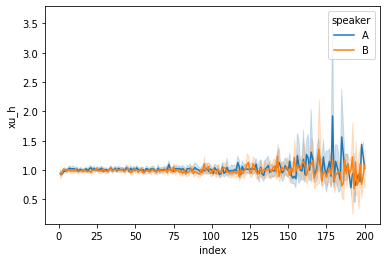

In [167]:
sns.lineplot(data=df[(df['index'] <= 200)], x="index", y="xu_h", hue="speaker")

In [14]:
xr = pd.read_csv('../data/swbd/xr_swbd.csv', index_col=0)
xr.head()

,convID,globalID,turnID,speaker,localID,wordNum,ent,treeDepth,branchingFactor,topicID,inTopicID,topicStarter,byTopicStarter,entc,turnLen
1,1,1,1,A,1,1,1.48789,0.974567,1.009080,1,1,A,True,0.281181,2
2,1,2,1,A,2,26,8.64813,1.172290,1.012350,1,2,A,True,0.832346,2
3,1,3,2,B,1,23,6.30240,1.144620,0.989632,1,3,A,False,0.613108,2
4,1,4,2,B,2,19,7.12943,0.588767,1.048340,1,4,A,False,0.692709,2
5,1,5,3,A,1,1,6.24289,0.974567,1.009080,2,1,A,True,1.179781,2


In [15]:
len(xr.convID.unique())

1126

In [31]:
df2 = pd.read_csv('../data/swbd/swb_dialogs_written.csv')
len(df2.file.unique())

2438

In [38]:
for i in range(100):
    f1 = xr[xr['convID'] == i+1].speaker.tolist()
    print(f'file {i+1} matches {dtest.apply(lambda x: x == f1).sum()}')

file 1 matches 0
file 2 matches 0
file 3 matches 0
file 4 matches 0
file 5 matches 0
file 6 matches 0
file 7 matches 0
file 8 matches 0
file 9 matches 0
file 10 matches 0
file 11 matches 0
file 12 matches 0
file 13 matches 0
file 14 matches 0
file 15 matches 0
file 16 matches 0
file 17 matches 0
file 18 matches 0
file 19 matches 0
file 20 matches 0
file 21 matches 0
file 22 matches 0
file 23 matches 0
file 24 matches 0
file 25 matches 0
file 26 matches 0
file 27 matches 0
file 28 matches 0
file 29 matches 0
file 30 matches 0
file 31 matches 0
file 32 matches 0
file 33 matches 0
file 34 matches 0
file 35 matches 0
file 36 matches 0
file 37 matches 0
file 38 matches 0
file 39 matches 0
file 40 matches 0
file 41 matches 0
file 42 matches 0
file 43 matches 0
file 44 matches 0
file 45 matches 0
file 46 matches 0
file 47 matches 0
file 48 matches 0
file 49 matches 0
file 50 matches 0
file 51 matches 0
file 52 matches 0
file 53 matches 0
file 54 matches 0
file 55 matches 0
file 56 matches 0
f

In [32]:
dtest = df2.groupby('file').agg({'speaker' : lambda x: list(x)[:100]}).speaker

In [33]:
dtest.apply(lambda x: x == f1).sum()

0

In [36]:
dtest.apply(lambda x: len(x) ==100).sum()

1026

others

In [40]:
df = pd.read_csv('/Users/neako/Downloads/gpt2-training_dialogue_id_1024.csv')
df.head()

,dialogue_id,speaker,transaction_number,transaction_type,move_number,move_type,position_in_dialogue,position_in_transaction,duration,text,h,normalised_h,length,tokens_h,tokens,xu_h
0,q1ec1,g,1,normal,1,ready,1,1,0.3294,okay,0.002824,0.002824,1,[-0.002824284601956606],['ay'],0.000352
1,q1ec1,g,1,normal,2,instruct,2,2,3.1785,starting off we are above a caravan park,67.286199,8.410775,8,"[-16.988040924072266, -5.4245781898498535, -14...","['starting', 'Ġoff', 'Ġwe', 'Ġare', 'Ġabove', ...",2.023425
2,q1ec1,f,1,normal,1,acknowledge,3,3,0.3459,mmhmm,9.403888,3.134629,3,"[-7.923971652984619, -1.4798786640167236, -3.8...","['mm', 'h', 'mm']",0.645524
3,q1ec1,g,1,normal,3,instruct,4,4,9.7612,we are going to go due south straight south an...,127.734159,3.870732,33,"[-8.610397338867188, -6.037899494171143, -3.70...","['we', 'Ġare', 'Ġgoing', 'Ġto', 'Ġgo', 'Ġdue',...",1.045134
4,q1ec1,f,1,normal,2,check,5,5,1.5487,due south and then back up again,31.045443,4.435063,7,"[-17.8077335357666, -0.10320039093494415, -3.9...","['due', 'Ġsouth', 'Ġand', 'Ġthen', 'Ġback', 'Ġ...",1.059908
